In [1]:

import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, Input
from tensorflow.keras.layers import Dropout, Bidirectional, GlobalMaxPooling1D, Concatenate
from tensorflow.keras.callbacks import EarlyStopping

np.random.seed(42)
tf.random.set_seed(42)

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

for directory in ['data', 'results']:
    os.makedirs(directory, exist_ok=True)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))



TensorFlow version: 2.18.0
GPU Available: []


In [ ]:

def load_text_dataset(filepath):
 
    try:
        if not os.path.exists(filepath):
            print(f"Warning: File '{filepath}' not found!")
            return create_sample_dataset()

        print(f"Loading data from '{filepath}'...")


        data = []
        with open(filepath, 'r', encoding='utf-8') as file:
            for line in file:
                if not line.strip():
                    continue

                parts = line.strip().split('\t')


                if len(parts) >= 5:

                    pmid = parts[0]
                    label = int(parts[1])
                    abstract = parts[4]

                    data.append({
                        'pmid': pmid,
                        'is_rct': label,
                        'abstract': abstract
                    })
                elif len(parts) == 4:

                    pmid = parts[0]
                    label = int(parts[1])
                    abstract = parts[3]

                    data.append({
                        'pmid': pmid,
                        'is_rct': label,
                        'abstract': abstract
                    })

            if data:
                df = pd.DataFrame(data)
                print(f"Successfully loaded {len(df)} records")
                print(f"Class distribution: {df['is_rct'].value_counts().to_dict()}")
                return df
            else:
                print("No valid data found in file")
                return create_sample_dataset()

    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return create_sample_dataset()

def create_sample_dataset():

    print("Creating sample dataset for demonstration...")
    abstracts = [
        "Background: Randomized controlled trials are critical for evidence-based medicine. Methods: We randomized 100 patients into treatment and control groups. Results: The treatment group showed significant improvement (p<0.05).",
        "We conducted a study on 50 volunteers to examine the effects of the treatment. The results were inconclusive and further research is needed.",
        "In this double-blind, placebo-controlled trial, 200 participants were randomly assigned to receive either the drug or placebo. The primary outcome was measured after 12 weeks.",
        "This observational study followed 150 patients for two years to assess long-term outcomes. No randomization was performed.",
        "Objectives: To determine efficacy of the new therapy. Design: Randomized, double-blind trial. Setting: 10 university hospitals. Participants: 300 patients with condition X. Intervention: Drug A vs placebo. Measurements: Primary outcome was symptom reduction.",
        "A retrospective analysis of hospital records was conducted to identify factors associated with readmission rates. We analyzed data from 500 patient records over a five-year period.",
        "Methods: In this randomized controlled trial, patients were allocated in a 1:1 ratio to receive treatment or placebo. All participants and researchers were blinded to the allocation.",
        "We performed a systematic review and meta-analysis of studies published between 2010-2020. A total of 25 studies with 3000 participants were included in the analysis."
    ]

    labels = [1, 0, 1, 0, 1, 0, 1, 0]  # 1 for RCT, 0 for non-RCT

    return pd.DataFrame({
        'abstract': abstracts,
        'is_rct': labels
    })


def clean_text(text):

    if pd.isna(text):
        return ""

    text = text.lower()

    text = re.sub(r'[^\w\s]', ' ', text)

    text = re.sub(r'\s+', ' ', text).strip()

    return text

def preprocess_data(data, sample_size=None):

    if sample_size and len(data) > sample_size:

        sampled_data = pd.DataFrame()
        for label in [0, 1]:
            class_data = data[data['is_rct'] == label]
            class_sample_size = min(sample_size // 2, len(class_data))
            class_sample = class_data.sample(n=class_sample_size, random_state=42)
            sampled_data = pd.concat([sampled_data, class_sample])


        processed_data = sampled_data.sample(frac=1, random_state=42).reset_index(drop=True)
        print(f"Using {len(processed_data)} samples (from original {len(data)} records)")
    else:
        processed_data = data.copy()


    processed_data['processed_text'] = processed_data['abstract'].apply(clean_text)

    missing_text = processed_data['processed_text'].isna().sum()
    missing_labels = processed_data['is_rct'].isna().sum()

    if missing_text > 0:
        print(f"Warning: {missing_text} records have missing text")

    if missing_labels > 0:
        print(f"Warning: {missing_labels} records have missing labels")
        processed_data = processed_data.dropna(subset=['is_rct'])

    return processed_data

def prepare_text_sequences(texts, max_words=5000, max_sequence_length=150):

    tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')


    tokenizer.fit_on_texts(texts)


    sequences = tokenizer.texts_to_sequences(texts)


    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

    print(f"Vocabulary size: {len(tokenizer.word_index) + 1}")
    print(f"Sequence shape: {padded_sequences.shape}")

    return tokenizer, padded_sequences



def build_bilstm_cnn_model(vocab_size, embedding_dim=100, max_sequence_length=150):

    inputs = Input(shape=(max_sequence_length,))
    embedding = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_sequence_length
    )(inputs)
    embedding = Dropout(0.2)(embedding)
    bilstm = Bidirectional(LSTM(64, return_sequences=True))(embedding)
    conv1 = Conv1D(filters=64, kernel_size=3, activation='relu')(bilstm)
    pool1 = GlobalMaxPooling1D()(conv1)

    conv2 = Conv1D(filters=64, kernel_size=5, activation='relu')(bilstm)
    pool2 = GlobalMaxPooling1D()(conv2)
    concatenated = Concatenate()([pool1, pool2])
    dropout = Dropout(0.5)(concatenated)
    outputs = Dense(1, activation='sigmoid')(dropout)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    print(model.summary())
    return model

def build_simple_lstm_model(vocab_size, embedding_dim=100, max_sequence_length=150):

    model = Sequential()
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_sequence_length
    ))

    model.add(Dropout(0.2))
    model.add(LSTM(100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    print(model.summary())
    return model

def build_simple_cnn_model(vocab_size, embedding_dim=100, max_sequence_length=150):

    model = Sequential()

    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_sequence_length
    ))

    model.add(Dropout(0.2))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))


    model.add(Dense(1, activation='sigmoid'))


    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    print(model.summary())
    return model

def train_model(model, X_train, y_train, X_val, y_val, epochs=5, batch_size=32, model_name="model"):


    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=2,
        restore_best_weights=True
    )


    start_time = time.time()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=1
    )
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")

    return history, model

def evaluate_model(model, X_test, y_test, model_name="Model"):

    start_time = time.time()


    y_pred_proba = model.predict(X_test, verbose=0)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    evaluation_time = time.time() - start_time
    print(f"Evaluation completed in {evaluation_time:.2f} seconds")


    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    try:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    except:
        roc_auc = 0.5


    print(f"\n{model_name} Evaluation Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")


    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)


    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba.flatten()
    }

    return metrics


def plot_training_history(history, model_name="Model"):

    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} - Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')


    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} - Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.tight_layout()
    plt.savefig(f'results/{model_name}_training_history.png')
    plt.show()

def plot_confusion_matrix(cm, model_name="Model"):

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks([0.5, 1.5], ['Non-RCT', 'RCT'])
    plt.yticks([0.5, 1.5], ['Non-RCT', 'RCT'])
    plt.savefig(f'results/{model_name}_confusion_matrix.png')
    plt.show()

def plot_roc_curve(y_test, y_pred_proba, model_name="Model"):

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.savefig(f'results/{model_name}_roc_curve.png')
    plt.show()

def plot_comparison_bar(metrics_dict, metric_name):

    plt.figure(figsize=(10, 6))

    models = list(metrics_dict.keys())
    values = [metrics_dict[model][metric_name] for model in models]

    colors = ['#3498db', '#2ecc71', '#e74c3c'][:len(models)]

    bars = plt.bar(models, values, color=colors)

    plt.title(f'Model Comparison - {metric_name}')
    plt.xlabel('Model')
    plt.ylabel(metric_name)
    plt.ylim(0, 1.0)
    plt.xticks(rotation=0)


    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(f'results/model_comparison_{metric_name}.png')
    plt.show()



def get_misclassified_examples(texts, y_true, y_pred, y_pred_proba, n_examples=3):


    misclassified_indices = np.where(y_true != y_pred)[0]

    if len(misclassified_indices) == 0:
        print("No misclassified examples found.")
        return pd.DataFrame()


    if len(misclassified_indices) > n_examples:

        probs = y_pred_proba[misclassified_indices]
        sorted_indices = misclassified_indices[np.argsort(probs)[::-1]]
        sample_indices = sorted_indices[:n_examples]
    else:
        sample_indices = misclassified_indices


    misclassified = []
    for idx in sample_indices:
        misclassified.append({
            'text': texts[idx],
            'true_label': y_true[idx],
            'predicted_label': y_pred[idx],
            'confidence': y_pred_proba[idx]
        })

    return pd.DataFrame(misclassified)

def analyze_keyword_presence(texts, y_true, y_pred):


    keywords = ['random', 'trial', 'placebo', 'blind', 'control', 'group']


    correct = y_true == y_pred
    misclassified = ~correct


    results = {}

    for keyword in keywords:

        pattern = r'\b' + keyword + r'\w*\b'


        presence_correct_rct = np.mean([bool(re.search(pattern, text.lower())) for text, y in zip(texts[correct], y_true[correct]) if y == 1])
        presence_correct_non_rct = np.mean([bool(re.search(pattern, text.lower())) for text, y in zip(texts[correct], y_true[correct]) if y == 0])
        presence_fp = np.mean([bool(re.search(pattern, text.lower())) for text, y, p in zip(texts[misclassified], y_true[misclassified], y_pred[misclassified]) if y == 0 and p == 1])
        presence_fn = np.mean([bool(re.search(pattern, text.lower())) for text, y, p in zip(texts[misclassified], y_true[misclassified], y_pred[misclassified]) if y == 1 and p == 0])

        results[keyword] = {
            'correct_rct': presence_correct_rct * 100,
            'correct_non_rct': presence_correct_non_rct * 100,
            'false_positive': presence_fp * 100,
            'false_negative': presence_fn * 100
        }

    return results

def plot_keyword_analysis(keyword_results):

    data = []
    for keyword, stats in keyword_results.items():
        for category, value in stats.items():
            data.append({
                'keyword': keyword,
                'category': category,
                'percentage': value
            })

    df = pd.DataFrame(data)

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='keyword', y='percentage', hue='category', data=df)
    plt.title('Keyword Presence Analysis')
    plt.xlabel('Keywords')
    plt.ylabel('Presence Percentage (%)')
    plt.legend(title='Category')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('results/keyword_analysis.png')
    plt.show()





Starting RCT Identification with Deep Learning...
Loading data from '/content/rct_data.txt'...
Successfully loaded 59190 records
Class distribution: {0: 46361, 1: 12829}
Using 1000 samples (from original 59190 records)
Train set: 700 samples
Validation set: 150 samples
Test set: 150 samples
Vocabulary size: 13637
Sequence shape: (700, 150)

Building and training LSTM model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 219ms/step - accuracy: 0.5448 - loss: 0.6761 - val_accuracy: 0.7333 - val_loss: 1.1550
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.7283 - loss: 0.8058 - val_accuracy: 0.8333 - val_loss: 0.4890
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.8823 - loss: 0.4138 - val_accuracy: 0.7600 - val_loss: 0.5255
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 0.8963 - loss: 0.3016 - val_accuracy: 0.8933 - val_loss: 0.3823
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.9453 - loss: 0.2780 - val_accuracy: 0.8733 - val_loss: 0.4724
Training completed in 26.82 seconds

Building and training CNN model...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.5186 - loss: 0.6922 - val_accuracy: 0.5733 - val_loss: 0.6706
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.7008 - loss: 0.6530 - val_accuracy: 0.7667 - val_loss: 0.5998
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.7861 - loss: 0.5618 - val_accuracy: 0.7533 - val_loss: 0.5177
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.8271 - loss: 0.4400 - val_accuracy: 0.8000 - val_loss: 0.4186
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.8639 - loss: 0.3389 - val_accuracy: 0.8733 - val_loss: 0.3126
Training completed in 11.31 seconds

Evaluating models...
Evaluation completed in 0.68 seconds

LSTM Evaluation Results:
Accuracy: 0.8867
Precision: 0.8718
Recall: 0.9067
F1 Score: 0.8889
ROC-AUC: 0.9221

Confusion Matrix:
[[65 10]
 [ 7 68]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88 

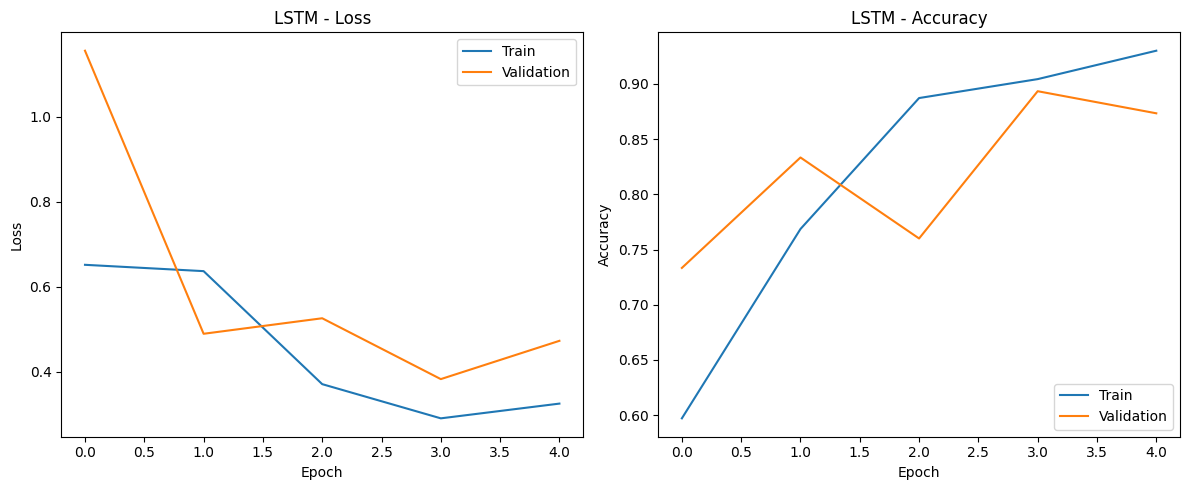

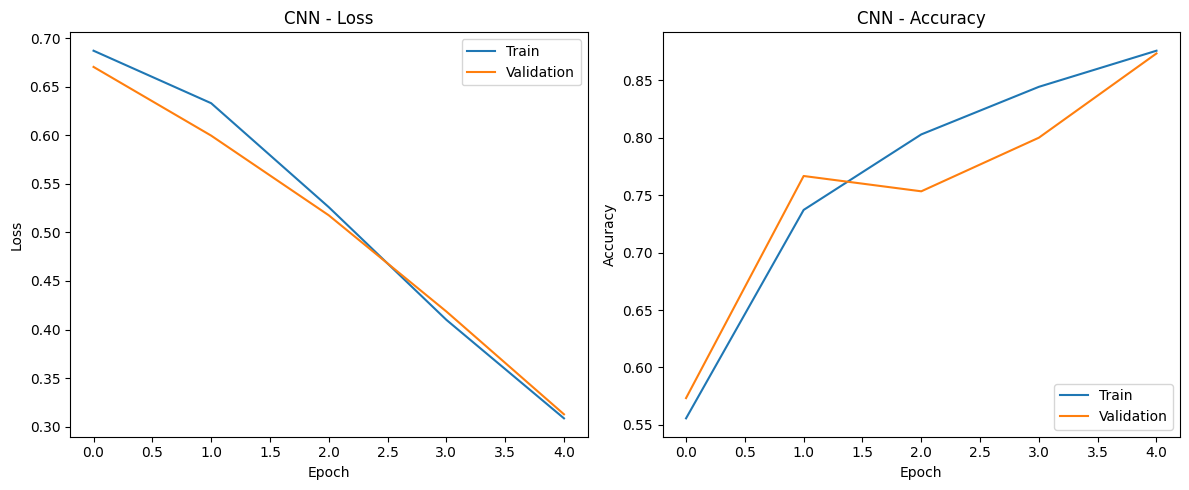

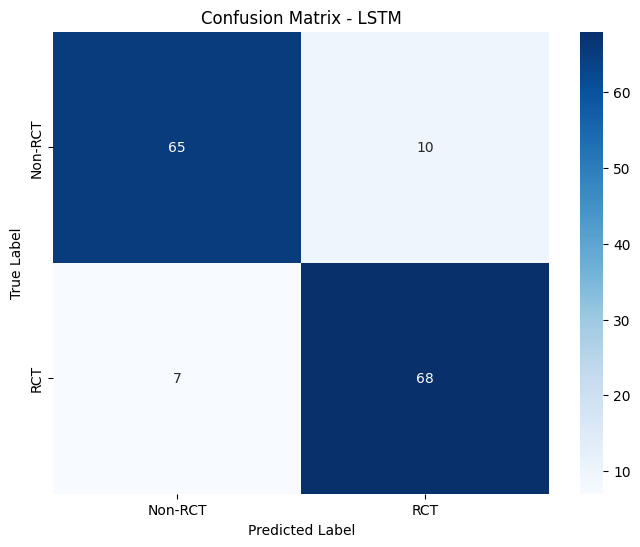

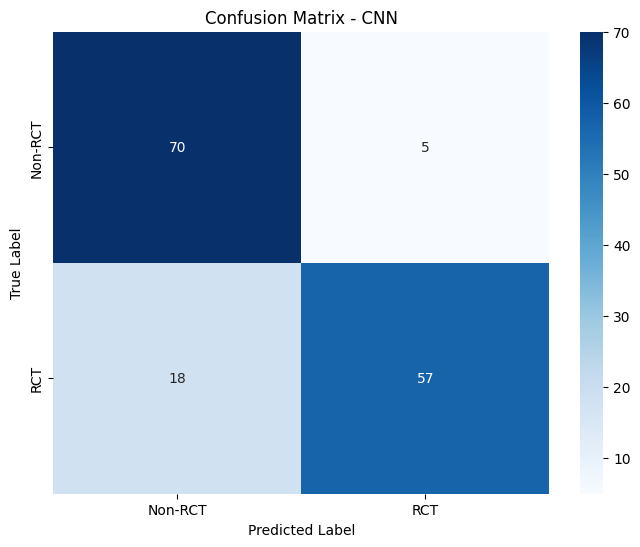

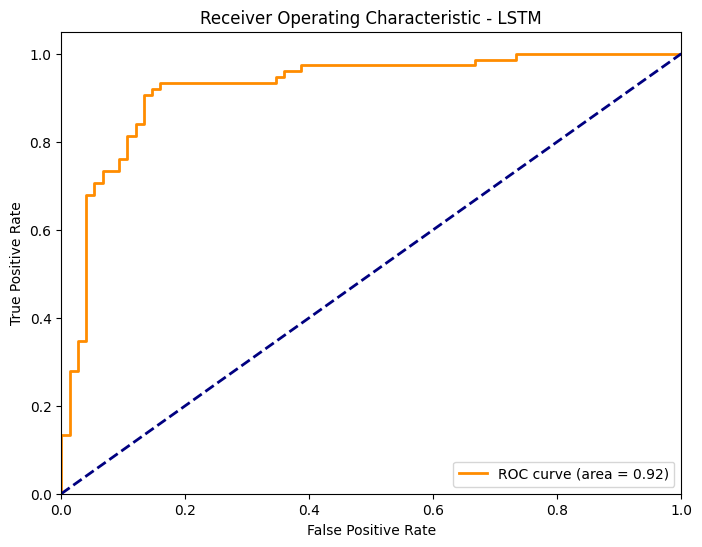

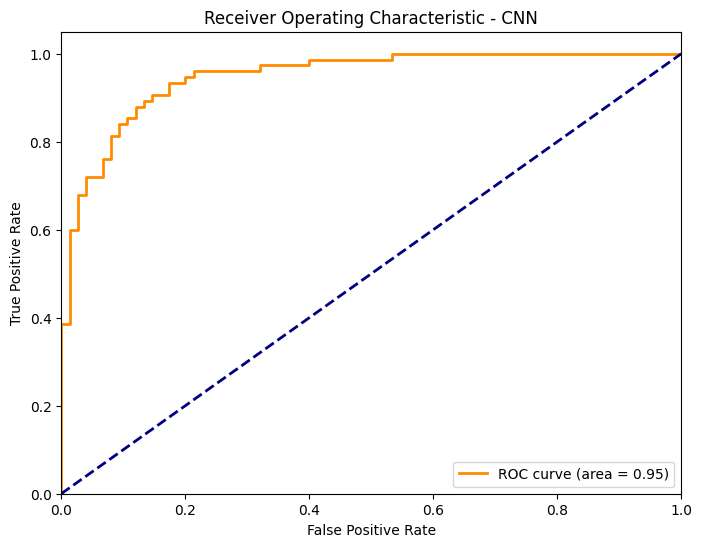

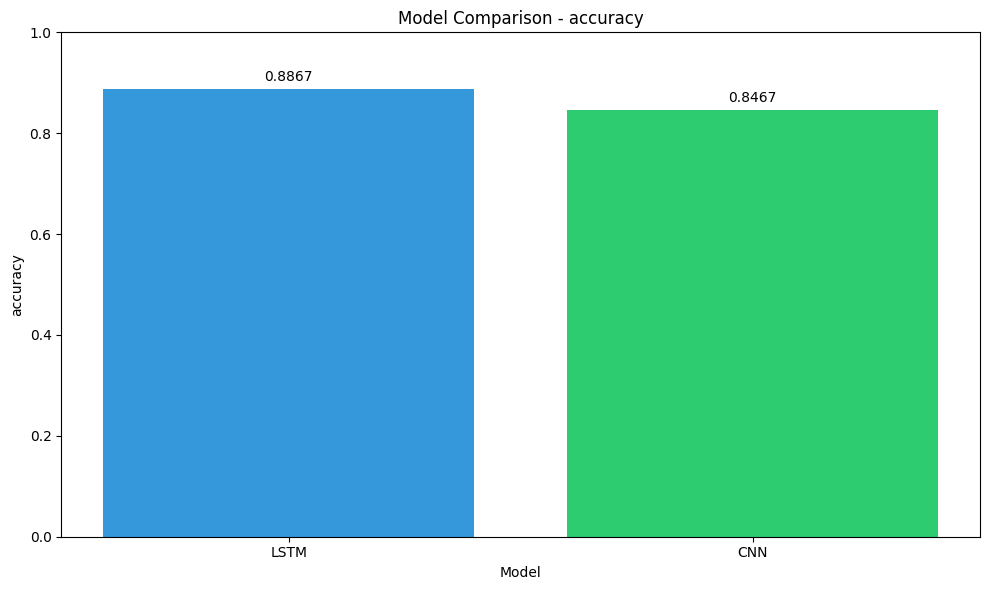

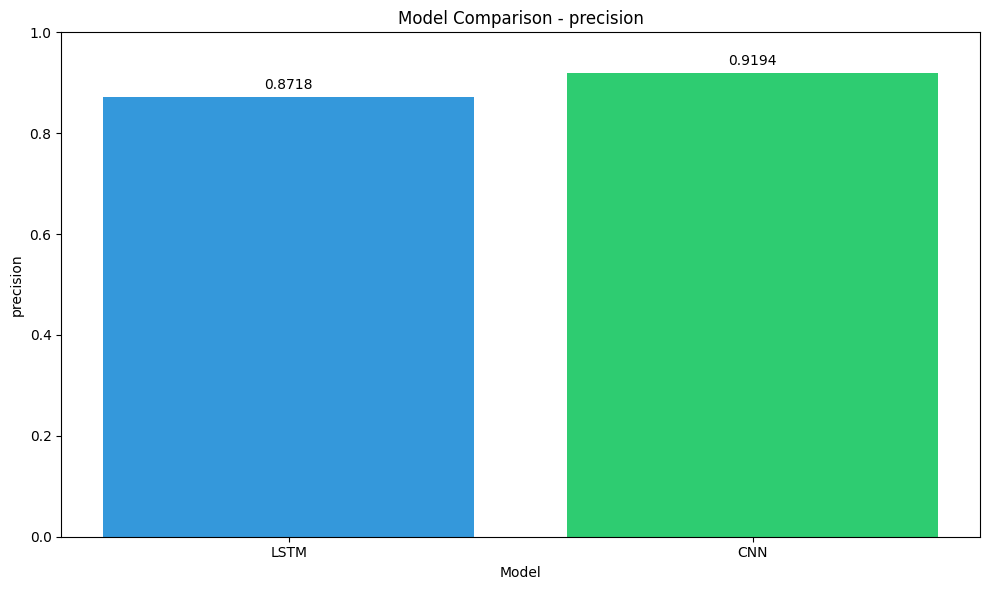

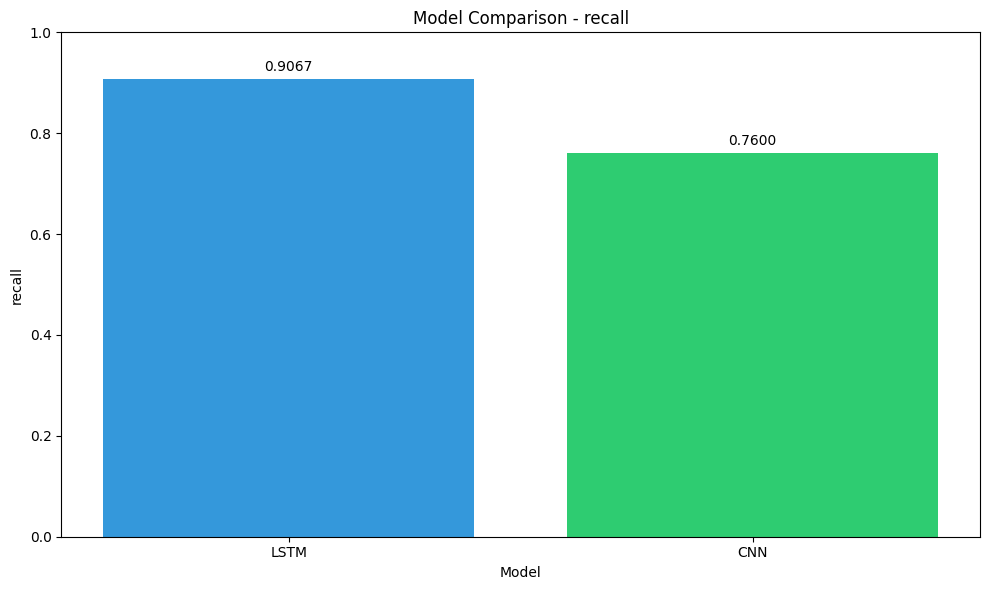

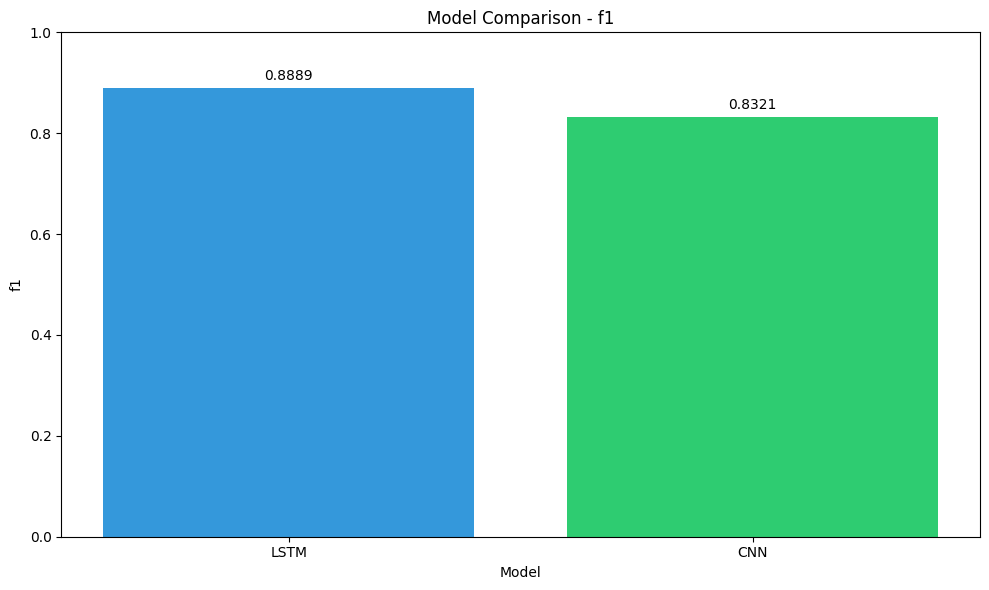

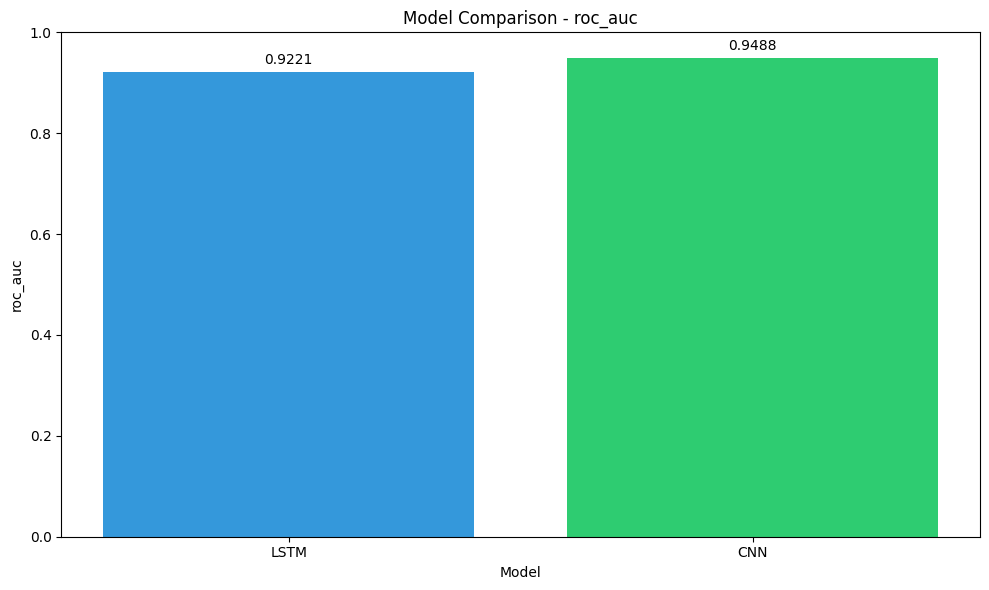


Using LSTM for detailed analysis as it had the best F1 score

Misclassified Examples:

True label: Non-RCT
Predicted label: RCT
Confidence: 0.9796
Text: multiple experiments have found sleep deprivation to lower task related parietal and extrastriate visual activation suggesting a reduction of visual p...

True label: Non-RCT
Predicted label: RCT
Confidence: 0.9789
Text: objective to assess the efficacy and safety of hyaluronate sodium hs for internal derangement of temporomandibular joint by means of systematic review...

True label: Non-RCT
Predicted label: RCT
Confidence: 0.9783
Text: protein elicits a stronger early 30 min glucose dependent insulinotropic polypeptide gip response than fat ingestion in lean individuals with no diffe...


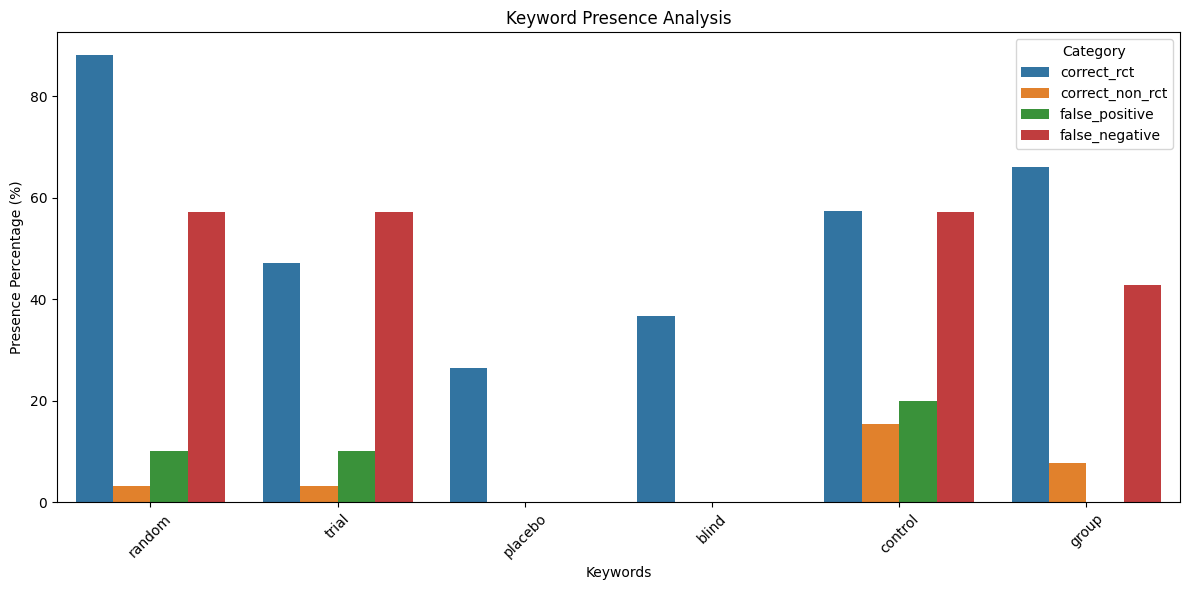


Total execution time: 45.51 seconds (0.76 minutes)
Results saved to 'results' directory


In [ ]:
def main():

    print("Starting RCT Identification with Deep Learning...")
    start_time = time.time()


    data_path = r'/content/rct_data.txt'
    data = load_text_dataset(data_path)


    sample_size = 1000
    processed_data = preprocess_data(data, sample_size=sample_size)


    X = processed_data['processed_text'].values
    y = processed_data['is_rct'].values

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

    print(f"Train set: {len(X_train)} samples")
    print(f"Validation set: {len(X_val)} samples")
    print(f"Test set: {len(X_test)} samples")


    max_words = 5000
    max_sequence_length = 150

    tokenizer, X_train_seq = prepare_text_sequences(X_train, max_words, max_sequence_length)
    X_val_seq = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=max_sequence_length, padding='post')
    X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_sequence_length, padding='post')


    vocab_size = min(max_words, len(tokenizer.word_index) + 1)
    embedding_dim = 100

    print("\nBuilding and training LSTM model...")
    lstm_model = build_simple_lstm_model(vocab_size, embedding_dim, max_sequence_length)
    lstm_history, lstm_model = train_model(
        lstm_model, X_train_seq, y_train, X_val_seq, y_val,
        epochs=5, batch_size=32, model_name="lstm"
    )

    print("\nBuilding and training CNN model...")
    cnn_model = build_simple_cnn_model(vocab_size, embedding_dim, max_sequence_length)
    cnn_history, cnn_model = train_model(
        cnn_model, X_train_seq, y_train, X_val_seq, y_val,
        epochs=5, batch_size=32, model_name="cnn"
    )


    print("\nEvaluating models...")

    lstm_metrics = evaluate_model(lstm_model, X_test_seq, y_test, "LSTM")
    cnn_metrics = evaluate_model(cnn_model, X_test_seq, y_test, "CNN")


    print("\nVisualizing results...")


    plot_training_history(lstm_history, "LSTM")
    plot_training_history(cnn_history, "CNN")


    plot_confusion_matrix(lstm_metrics['confusion_matrix'], "LSTM")
    plot_confusion_matrix(cnn_metrics['confusion_matrix'], "CNN")


    plot_roc_curve(y_test, lstm_metrics['y_pred_proba'], "LSTM")
    plot_roc_curve(y_test, cnn_metrics['y_pred_proba'], "CNN")


    metrics_dict = {
        "LSTM": lstm_metrics,
        "CNN": cnn_metrics
    }

    for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
        plot_comparison_bar(metrics_dict, metric)


    best_model_name = max(metrics_dict, key=lambda k: metrics_dict[k]['f1'])
    best_metrics = metrics_dict[best_model_name]

    print(f"\nUsing {best_model_name} for detailed analysis as it had the best F1 score")


    misclassified = get_misclassified_examples(
        X_test, y_test, best_metrics['y_pred'], best_metrics['y_pred_proba']
    )

    if not misclassified.empty:
        print("\nMisclassified Examples:")
        for _, example in misclassified.iterrows():
            print(f"\nTrue label: {'RCT' if example['true_label'] == 1 else 'Non-RCT'}")
            print(f"Predicted label: {'RCT' if example['predicted_label'] == 1 else 'Non-RCT'}")
            print(f"Confidence: {example['confidence']:.4f}")
            print(f"Text: {example['text'][:150]}...")


    keyword_results = analyze_keyword_presence(X_test, y_test, best_metrics['y_pred'])
    plot_keyword_analysis(keyword_results)

    total_time = time.time() - start_time
    print(f"\nTotal execution time: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
    print("Results saved to 'results' directory")

if __name__ == "__main__":
    main()